# Visualización de Muestra de Datos

## Cargando datos

Abriendo librerias y muestra de datos...

In [1]:
import sys
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

In [3]:
!cp /kaggle/input/balanced-1m-doublets/balanced1M_pixelTracksHitDoublets_dnn_doublets.h5 .
data_files = '/kaggle/input/balanced-1m-doublets/balanced1M_pixelTracksHitDoublets_dnn_doublets.h5'
data_sample = pd.read_hdf(data_files)

A continuación puede verse una pequeña muestra de los datos

In [3]:
data_sample.head()

,run,evt,lumi,PU,detSeqIn,detSeqOut,bSX,bSY,bSZ,bSdZ,...,outPixelZero,outAvgCharge,outOverFlowX,outOverFlowY,outSkew,outIsBig,outIsBad,outIsEdge,deltaPhi,label
7699978,1,6355,11,61,0,29,0,0,0.00005,4,...,7100,11242.0,0,0,2.0,0,0,0,-0.024430,-1
4844175,1,6344,11,53,0,1,0,0,0.00005,4,...,4019,19826.5,0,0,2.0,0,0,0,0.061533,-1
481408,1,6326,11,43,30,31,0,0,0.00005,4,...,12195,9869.5,0,0,2.0,0,0,0,0.014251,1
5966327,1,6348,11,36,14,15,0,0,0.00005,4,...,19304,10934.5,0,0,0.5,0,0,0,-0.001167,-1
8500908,1,6359,11,54,0,1,0,0,0.00005,4,...,6344,14359.0,0,0,0.5,0,0,0,-0.058357,1


## Clasificando dobletes

Se hace distinción entre dobletes verdaderos (True) o falsos (False)

In [20]:
true_doublets = (data_sample["label"] == 1)
false_doublets = (data_sample["label"] == -1)

In [21]:
data_true = data_sample[true_doublets]
data_false = data_sample[false_doublets]

También entre dobletes cuyos *hits* den en:
* Los dos en el **barrel** ==> bb_doublets
* Uno en el **barrel** y otro en los **endcaps** ==> be_doublets
* Los dos en los **endcaps** ==> ee_doublets

In [16]:
bb_doublets = ((data_sample["inIsBarrel"] == 1) & (data_sample["outIsBarrel"] == 1)) 
be_doublets = ((data_sample["inIsBarrel"] == 1) & (data_sample["outIsBarrel"] == 0.0)) 
ee_doublets = ((data_sample["inIsBarrel"] == 0.0) & (data_sample["outIsBarrel"] == 0.0))

In [17]:
data_bb = data_sample[bb_doublets]
data_be = data_sample[be_doublets]
data_ee = data_sample[ee_doublets]

## Mostrando Datos

### Visualización de la geometría del detector

Para observar las distintas capas y discos del píxel, debido a la gran cantidad de datos de *hits* de la que se dispone, al representarlos todos se observará una acumulación en las zonas activas del detector, lo que permite intuir su estructura geométrica

In [8]:
def representar(data, titulos, coor):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(data[coor[0]], data[coor[1]], "o", color="steelblue", markersize=2)
    ax = plt.gca()
    plt.title(f"Inner Hit en Dobletes {titulos[0]}", fontsize=15, fontweight="bold")
    plt.ylabel(f"{titulos[1]} (cm)", fontsize=12, fontstyle="italic")
    plt.xlabel(f"{titulos[2]} (cm)", fontsize=12, fontstyle="italic")
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.subplot(1, 2, 2)
    plt.plot(data[coor[2]], data[coor[3]], "o", color="mediumpurple", markersize=2)
    ax = plt.gca()
    plt.title(f"Outer Hit en Dobletes {titulos[0]}", fontsize=15, fontweight="bold")
    plt.ylabel(f"{titulos[1]} (cm)", fontsize=12, fontstyle="italic")
    plt.xlabel(f"{titulos[2]} (cm)", fontsize=12, fontstyle="italic")
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.show()

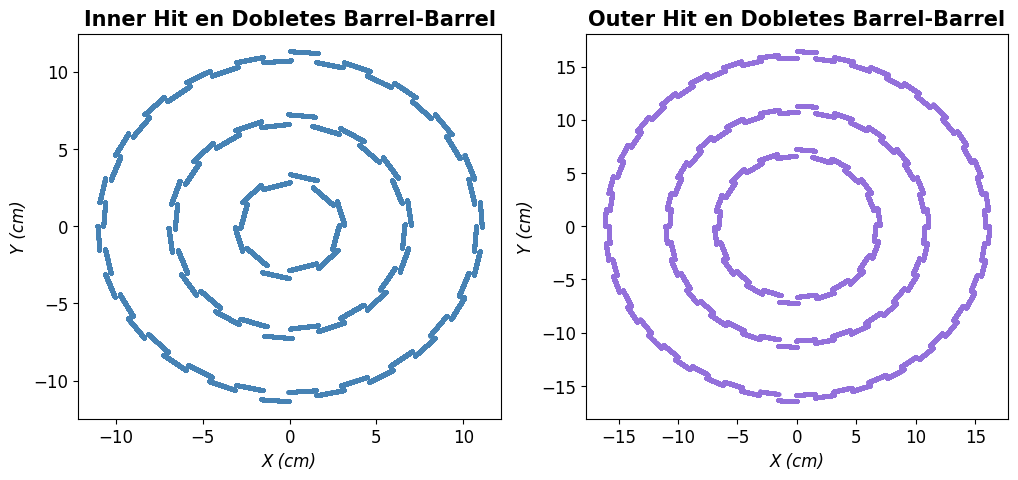

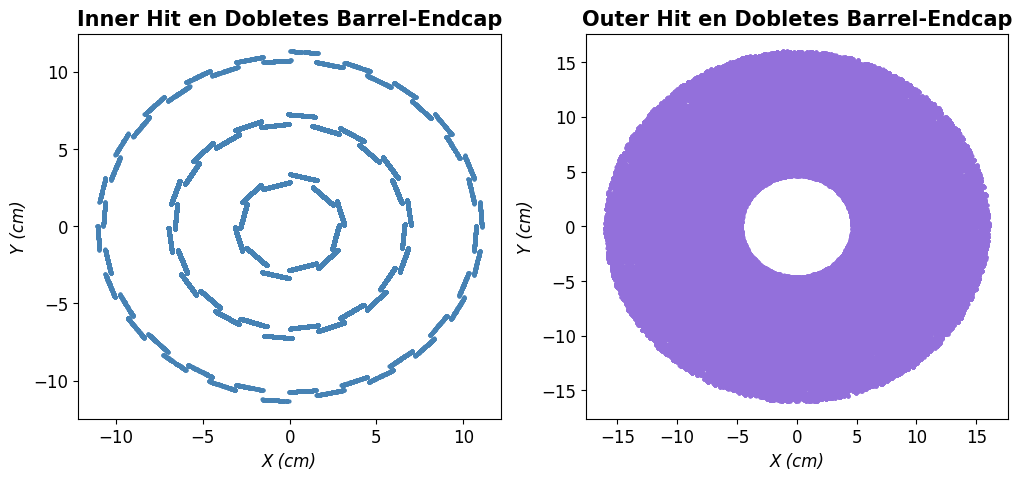

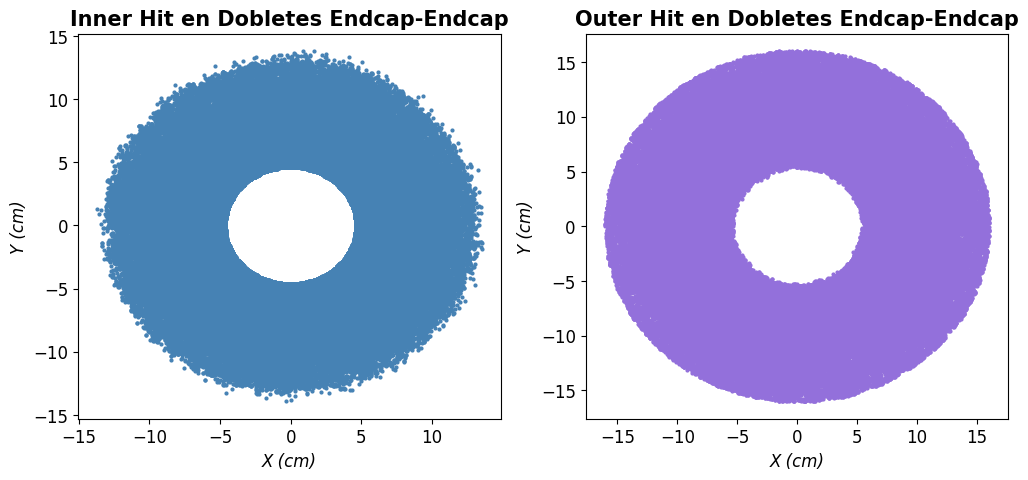

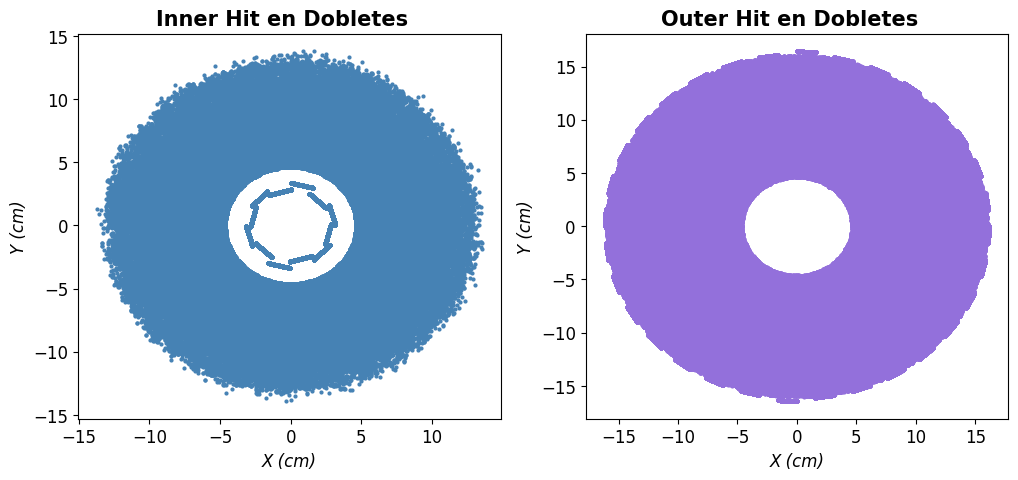

In [9]:
representar(data_bb, ["Barrel-Barrel","Y","X"], ["inX","inY","outX","outY"])
representar(data_be, ["Barrel-Endcap","Y","X"], ["inX","inY","outX","outY"])
representar(data_ee, ["Endcap-Endcap","Y","X"], ["inX","inY","outX","outY"])
representar(data_sample, [" ","Y","X"], ["inX","inY","outX","outY"])

Es importante tener en cuenta que el pixel tiene 4 capas en el *barrel*, pero:
* En la grafica Inner Hit se ven solo 3 capas porque estamos hablando de la primera señal que deja el miembro del doblete (vemos las 3 primeras). No vemos la capa 4 porque siempre debe haber depositado energía mas adentro.

* En la gráfica Outer vemos de nuevo 3 capas excluyendo ahora la primera porque asumimos que el primer rastro nunca se puede dejar en la primera capa porque sino sería Inner.


Los discos de los *endcaps* **no** son visibles en el plano x-y

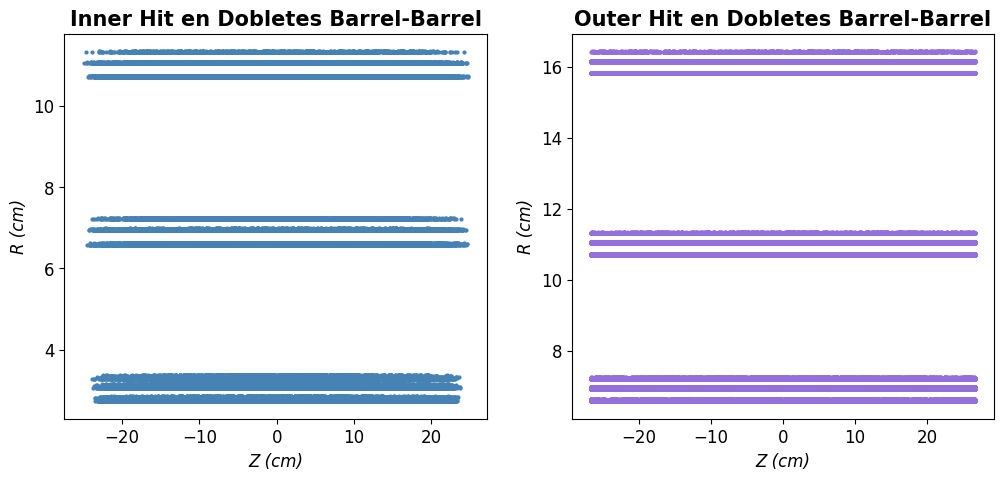

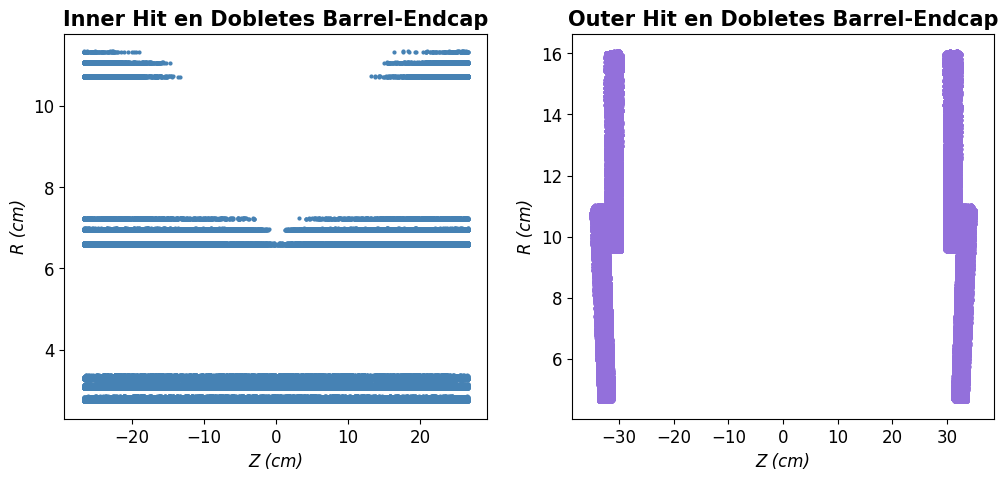

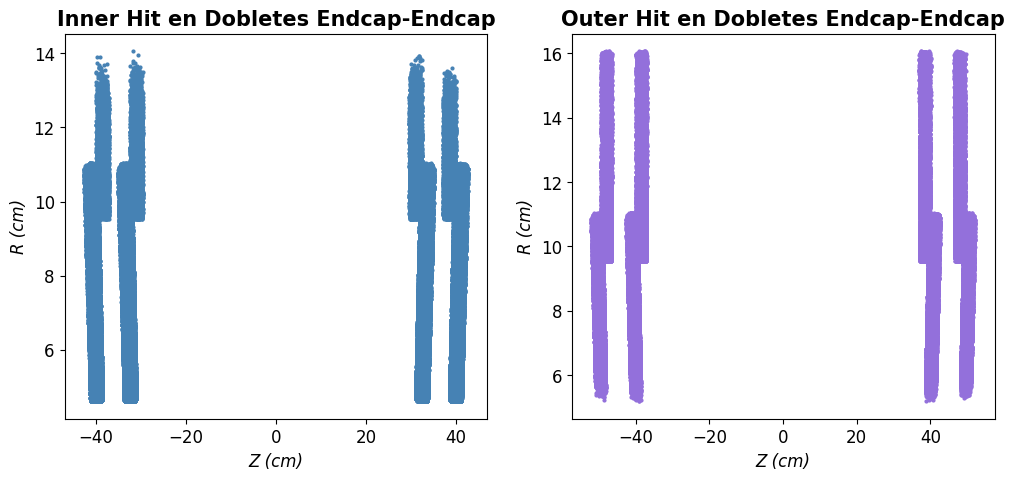

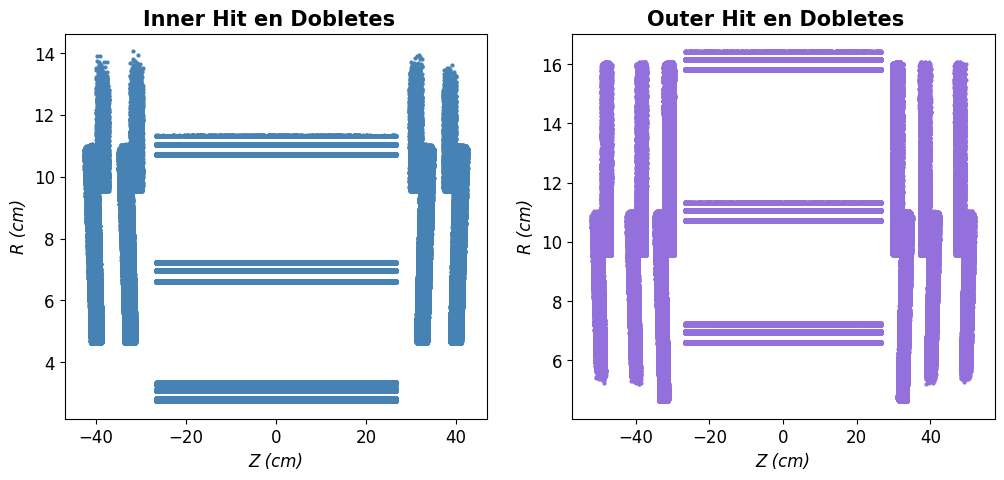

In [10]:
representar(data_bb, ["Barrel-Barrel","R","Z"], ["inZ","inR","outZ","outR"])
representar(data_be, ["Barrel-Endcap","R","Z"], ["inZ","inR","outZ","outR"])
representar(data_ee, ["Endcap-Endcap","R","Z"], ["inZ","inR","outZ","outR"])
representar(data_sample, [" ","R","Z"], ["inZ","inR","outZ","outR"])

En el plano r-z se advierten tanto las capas del *barrel* como los discos de los *endcaps*. De nuevo hay que tener las en cuenta las consideraciones entre Inner y Outer que se comentaban previamente.

### Visualización de Algunos Dobletes

Se muestran en el plano r-z la unión de algunos pares de *hits* tanto verdaderos (True), en color azul, como falsos (False) en color rojo.

Para representar las capas y discos (en color gris) se usa la técnica que se mencionó anteriormente.

/tmp/ipykernel_35/1241132472.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/kaggle/working/visu_dob.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


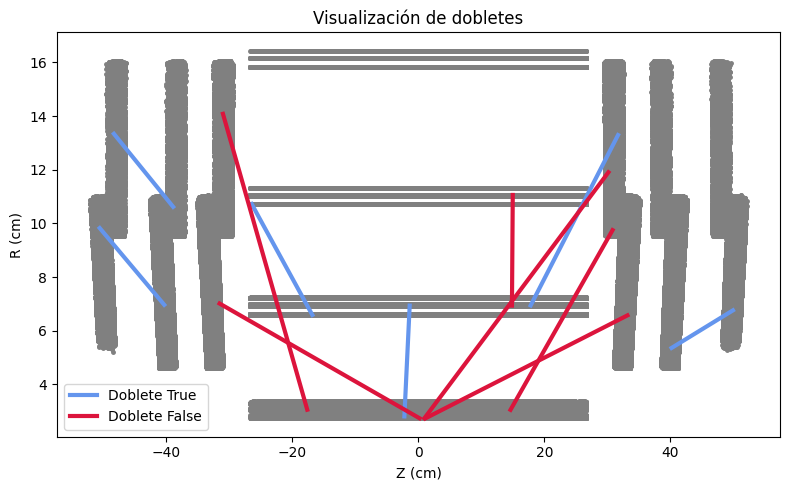

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(data_sample["inZ"],data_sample["inR"],"o",color="grey",markersize=2.5)
plt.plot(data_sample["outZ"],data_sample["outR"],"o",color="grey",markersize=2.5)


plt.plot(data_true[["inZ","outZ"]].values[0],data_true[["inR","outR"]].values[0],lw=3.0,color="cornflowerblue",label="Doblete True")
for i in range(5):
    u = int(random.uniform(0, data_true.shape[0]))
    plt.plot(data_true[["inZ","outZ"]].values[u],data_true[["inR","outR"]].values[u],lw=3.0,color="cornflowerblue")

plt.plot(data_false[["inZ","outZ"]].values[0],data_false[["inR","outR"]].values[0],lw=3.0,color="crimson",label="Doblete False")
for i in range(5):
    u = int(random.uniform(0, data_false.shape[0]))
    plt.plot(data_false[["inZ","outZ"]].values[u],data_false[["inR","outR"]].values[u],lw=3.0,color="crimson")

ax.set_xlabel("Z (cm)")
ax.set_ylabel("R (cm)")
ax.set_title("Visualización de dobletes")
plt.tight_layout()
ax.legend()
plt.savefig('/kaggle/working/visu_dob.png')
plt.show()

También se añade representación en el plano x-y. Esta **no es muy prometedora** ya que no permite visualizar la curvatura de las trayectorias al tratar solamente con dobletes, ni tampoco los choques en los *endcaps*

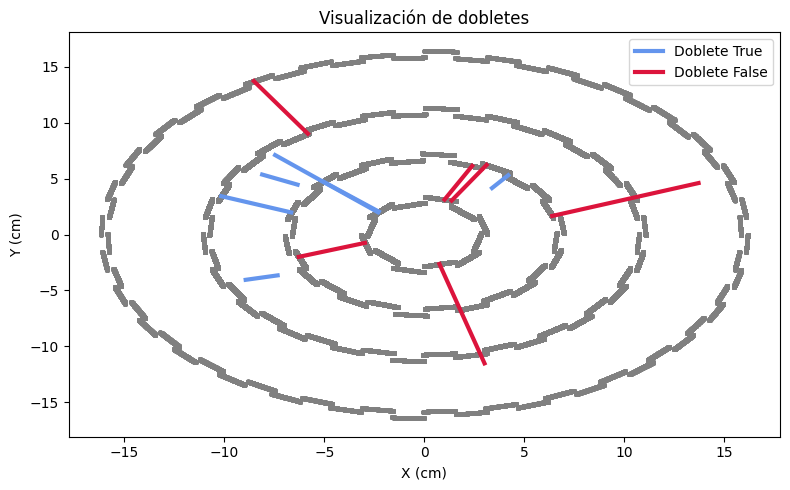

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(data_sample[bb_doublets]["inX"],data_sample[bb_doublets]["inY"],"o",color="grey",markersize=2.5)
plt.plot(data_sample[bb_doublets]["outX"],data_sample[bb_doublets]["outY"],"o",color="grey",markersize=2.5)

plt.plot(data_true[["inX","outX"]].values[0],data_true[["inY","outY"]].values[0],lw=3.0,color="cornflowerblue",label="Doblete True")
for i in range(5):
    u = int(random.uniform(0, data_true.shape[0]))
    plt.plot(data_true[["inX","outX"]].values[u],data_true[["inY","outY"]].values[u],lw=3.0,color="cornflowerblue")

plt.plot(data_false[["inX","outX"]].values[0],data_false[["inY","outY"]].values[0],lw=3.0,color="crimson",label="Doblete False")
for i in range(5):
    u = int(random.uniform(0, data_true.shape[0]))
    plt.plot(data_false[["inX","outX"]].values[u],data_false[["inY","outY"]].values[u],lw=3.0,color="crimson")

ax.set_xlabel("X (cm)")
ax.set_ylabel("Y (cm)")
ax.set_title("Visualización de dobletes")
plt.tight_layout()
ax.legend()
plt.show()

Se añade también una representación 3d. De nuevo **tampoco es prometedora** por las mismas razones que la anterior.

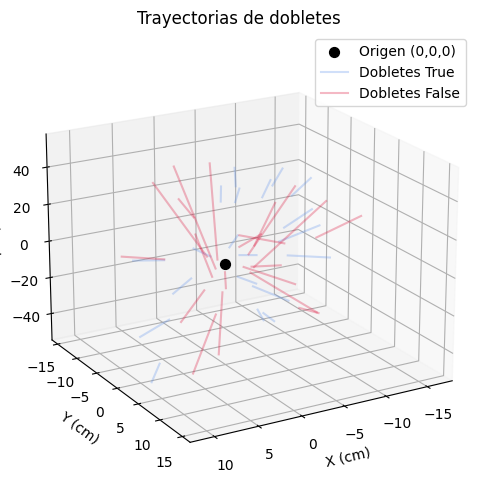

In [13]:
n_to_plot = 20
true_doublets_rand = data_sample[true_doublets].sample(n=n_to_plot, random_state=42)
false_doublets_rand = data_sample[false_doublets].sample(n=n_to_plot, random_state=42)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(0, 0, 0, color='black', s=50, label='Origen (0,0,0)')

for i, row in true_doublets_rand.reset_index(drop=True).iterrows():
    xs = [row['inX'], row['outX']]
    ys = [row['inY'], row['outY']]
    zs = [row['inZ'], row['outZ']]
    if i==0:
        ax.plot(xs, ys, zs, color='cornflowerblue', alpha=0.3, label= 'Dobletes True')
    else:
        ax.plot(xs, ys, zs, color='cornflowerblue', alpha=0.3)

for i, row in false_doublets_rand.reset_index(drop=True).iterrows():
    xs = [row['inX'], row['outX']]
    ys = [row['inY'], row['outY']]
    zs = [row['inZ'], row['outZ']]
    if i==0:
        ax.plot(xs, ys, zs, color='crimson', alpha=0.3, label= 'Dobletes False')
    else:
        ax.plot(xs, ys, zs, color='crimson', alpha=0.3)

ax.set_xlabel("X (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("Z (cm)")
ax.set_title("Trayectorias de dobletes ")
ax.legend()
ax.view_init(elev=20, azim=60)
plt.show()

### Visualización de Variables

A continuación se muestra una representación de algunas de las variables en forma de histograma y dividiendo entre dobletes verdaderos y falsos. Este análisis exploratorio busca encontrar variables que pueden ser interesantes para entrenar el modelo de aprendizaje automático.

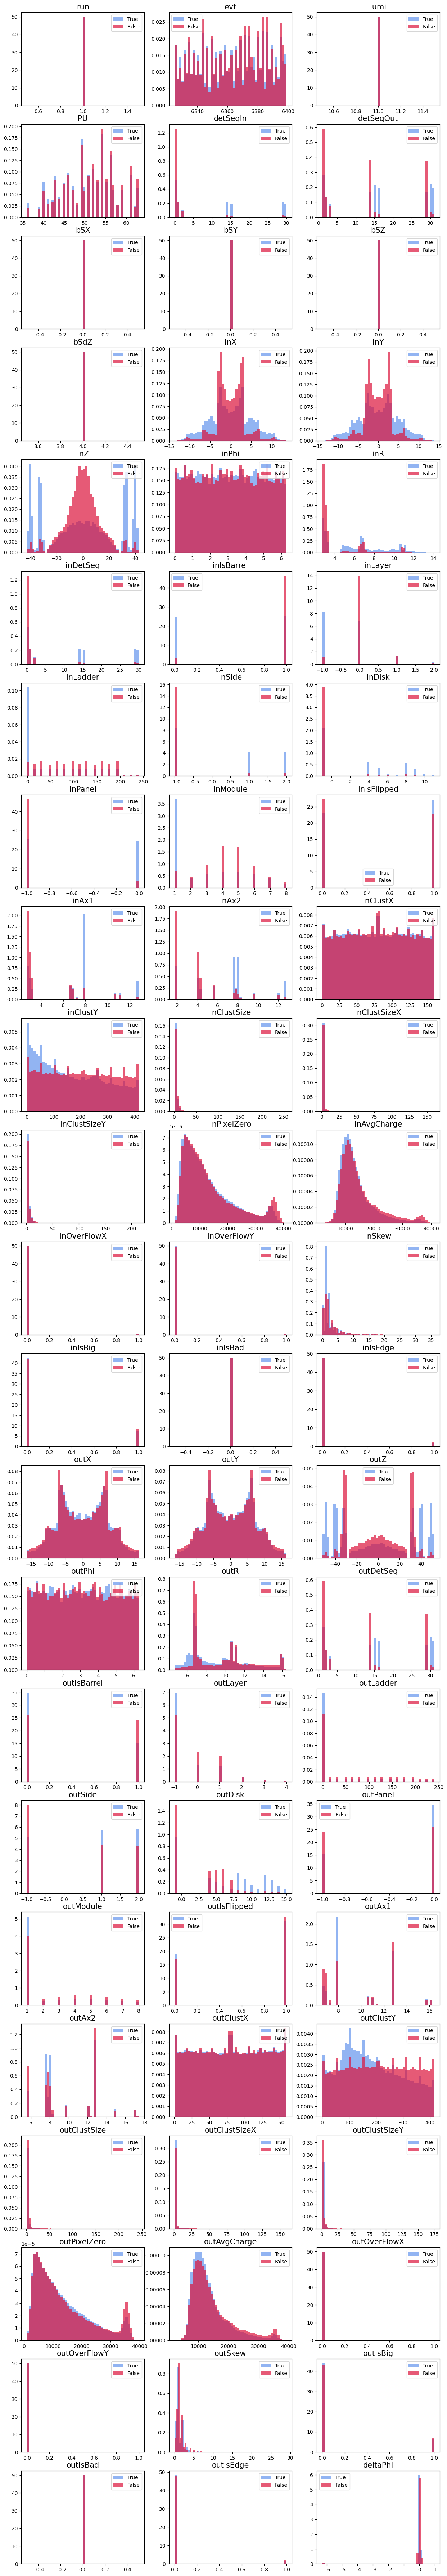

In [27]:
features = data_sample.select_dtypes(include='number').drop(columns=['label'])
cols = features.columns
n = len(cols)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(data_true[col], bins=50, alpha=0.7, label='True', color='cornflowerblue', density=True)
    ax.hist(data_false[col], bins=50, alpha=0.7, label='False', color='crimson', density=True)
    ax.set_title(col, fontsize=15)
    ax.legend()
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig('/kaggle/working/4.todasvariables.png')
plt.show()

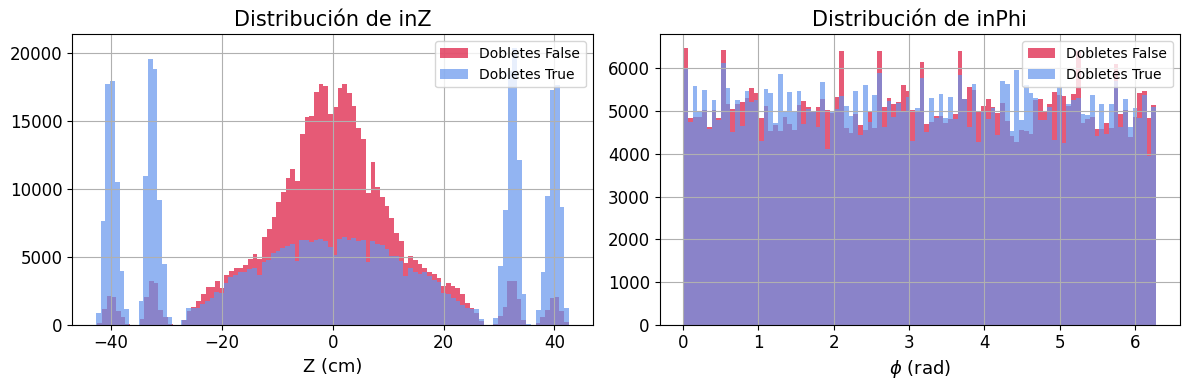

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axs[0].hist(data_sample[false_doublets]["inZ"],color="crimson",alpha=0.7,bins=100,label="Dobletes False")
axs[0].hist(data_sample[true_doublets]["inZ"],color="cornflowerblue",alpha=0.7,bins=100,label="Dobletes True")
axs[0].set_xlabel('Z (cm)',fontsize=13)
axs[0].set_title('Distribución de inZ', fontsize=15)
axs[0].grid()
axs[0].legend(fontsize=10)
axs[0].tick_params(axis='both', labelsize=12)

axs[1].hist(data_sample[false_doublets]["inPhi"],color="crimson",alpha=0.7,bins=100,label="Dobletes False")
axs[1].hist(data_sample[true_doublets]["inPhi"],color="cornflowerblue",alpha=0.7,bins=100,label="Dobletes True")
axs[1].set_xlabel('$\phi$ (rad)',fontsize=13)
axs[1].set_title('Distribución de inPhi', fontsize=15)
axs[1].grid()
axs[1].legend(fontsize=10)
axs[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/selecvariables.png')
plt.show()

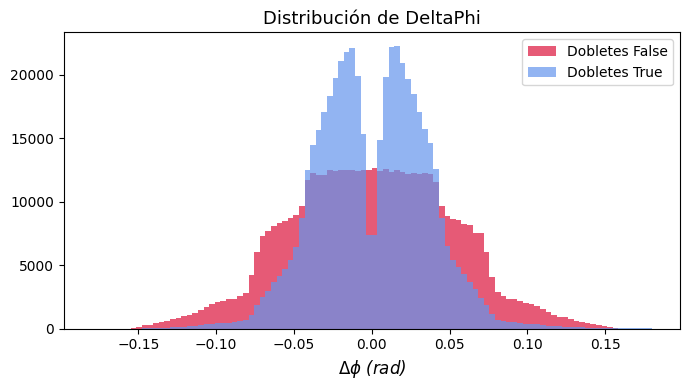

In [11]:
plt.figure(figsize=(7,4))
plt.hist(data_sample[false_doublets]["deltaPhi"],color="crimson",alpha=0.7,bins=100,range=(-0.18,0.18),label="Dobletes False")
plt.hist(data_sample[true_doublets]["deltaPhi"],color="cornflowerblue",alpha=0.7,bins=100,range=(-0.18,0.18),label="Dobletes True")
plt.title("Distribución de DeltaPhi",fontsize=13)
plt.xlabel("$\Delta \phi$ (rad)",fontsize=12,fontstyle="italic")
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/DeltaPhi.png')
plt.show()